In [1]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import os
import sys
import pickle as pkl
import ast
import pandas as pd
import random
import json 
import pickle
from tqdm import tqdm
from scipy.sparse import lil_matrix
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
import math
import scanpy as sc
import anndata as ad
from scipy import stats
import squidpy as sq
import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyArrowPatch, ArrowStyle
torch.backends.cudnn.enable =True
torch.backends.cudnn.benchmark = True
import warnings
warnings.filterwarnings('ignore')  # Disable all warnings

In [2]:
import RegChat

# Load data

In [3]:
path = '/Users/lihuazhang/Documents/projects/RegChat/RegChat_code/Dataset/ISSAAC/'
signaling_pathway = pd.read_csv(path + 'ISSAAC_db.csv')
gene_cell_pd = pd.read_csv(path + 'RNAmatrix.csv',sep=',',index_col=0)
cell_type = pd.read_csv(path + 'combined_cell_type.txt',sep='\t')
cell_type.index = gene_cell_pd.columns

In [4]:
X = gene_cell_pd.to_numpy()
coord = pd.read_csv(path + 'Coord.csv',sep=',',index_col=0)
intersection = list(set(coord.index.tolist()) & set(gene_cell_pd.columns.tolist()))
len(intersection)

2552

In [5]:
coord.index = gene_cell_pd.columns
# build adata for RNA-seq
obs = pd.DataFrame({
    'cell_type': cell_type['cell_type']
}, index= gene_cell_pd.columns)
var = pd.DataFrame({
    'gene_name': gene_cell_pd.index
}, index=gene_cell_pd.index)
# Initialize AnnData
adata_rna = ad.AnnData(X=X.T, obs=obs, var=var)
print(adata_rna)
adata_rna.obsm['spatial'] = coord.values
counts_type = obs['cell_type'].value_counts(dropna=False)
print(counts_type)

AnnData object with n_obs × n_vars = 2552 × 32285
    obs: 'cell_type'
    var: 'gene_name'
cell_type
Ex-L2/3 IT    850
Ex-L4/5 IT    689
Ex-L6 CT      299
Ex-L6 IT      242
Astro         217
Ex-L5 PT      154
Ex-L6b         51
Ex-L5 NP       45
Oligo           5
Name: count, dtype: int64


In [6]:
# remove Oligo data because less than 10
condition = adata_rna.obs['cell_type'] != 'Oligo'
indices = adata_rna.obs['cell_type'][condition].index.tolist()

In [7]:
adata_rna = adata_rna[indices,:].copy()
adata_rna.obsm['spatial'].shape

(2547, 2)

In [8]:
# take out Astro to do subcluster based on spatial location 
condition = adata_rna.obs['cell_type'] == 'Astro'
indices = adata_rna.obs['cell_type'][condition].index.tolist()
adata_rna_Astro = adata_rna[indices,:].copy()

In [9]:
adata_Astro_sp = ad.AnnData(X=adata_rna_Astro.obsm['spatial'], obs=adata_rna_Astro.obs,obsm = adata_rna_Astro.obsm)

In [10]:
sc.pp.neighbors(adata_Astro_sp)
sc.tl.leiden(adata_Astro_sp, resolution = 0.1)
# combine clusters
cell_type_new = []
#Astro_uniq = list(set(adata_Astro_sp.obs['leiden'].tolist()))
condition_1a = adata_Astro_sp.obs['leiden'] == '2'
condition_1b = adata_Astro_sp.obs['leiden'] == '4'
condition_1c = adata_Astro_sp.obs['leiden'] == '1'
condition_1 = condition_1a+condition_1b+condition_1c

In [11]:
indices_1 = adata_Astro_sp.obs['leiden'][condition_1].index.tolist()
cell_type = adata_rna.obs['cell_type']
cell_type = cell_type.astype('category')

In [13]:
cell_type = cell_type.cat.add_categories(['Astro_1'])
# change the index_1 to Astro_1
cell_type.loc[indices_1] = ['Astro_1']*len(indices_1)

In [16]:
adata_rna.obs['cell_type_new'] = cell_type

In [17]:
condition_final = adata_rna.obs['cell_type_new'] != 'Astro'
indices_final = adata_rna.obs['cell_type_new'][condition_final].index.tolist()
adata_rna_final = adata_rna[indices_final,:].copy()

[<Axes: title={'center': 'cell_type_new'}, xlabel='spatial1', ylabel='spatial2'>]

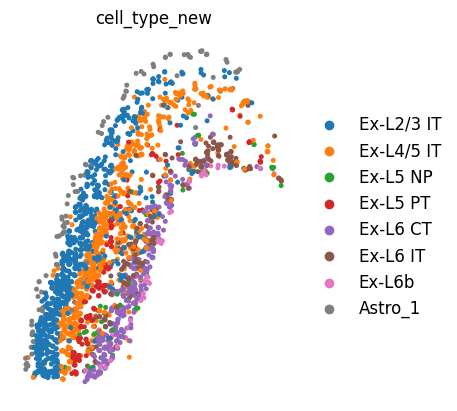

In [18]:
sc.pl.spatial(adata_rna_final, img_key=None, color=['cell_type_new'], 
                      legend_fontsize=12, show=False, frameon=False,
                      spot_size=100)

In [19]:
# add ref to label
from RegChat import model
adata_rna_final = model.label_to_int(adata_rna_final)

In [20]:
# run UMAP
sc.tl.pca(adata_rna_final)
sc.pp.neighbors(adata_rna_final)  
sc.tl.umap(adata_rna_final)

In [21]:
spot_loc = pd.DataFrame(data = adata_rna_final.obsm['spatial'], index = adata_rna_final.obs.index, columns = ['x','y'])

In [22]:
gene_cell_pd = pd.DataFrame(data = adata_rna_final.X.T, index = adata_rna_final.var.index, columns = adata_rna_final.obs.index)

In [23]:
from RegChat import Train_CCC_model

In [24]:
result_LR, result_LRFG, result_LG,H, score_l_record, score_g_record, tfg_l, CCI_strength_pd, LRFG_strength_pd, LG_strength_pd, CCI_score_pd, LRFG_score_pd,LRF_score_pd, LG_score_pd, nei_adj = Train_CCC_model(adata_rna = adata_rna_final, links_database = signaling_pathway, gene_cell_pd =gene_cell_pd,spot_loc=spot_loc, hidden_dim = 5, attn_drop = 0.0, layers_hidden=10, tau = 0.8, locMeasure='euclidean', lamb_1=1, lamb_2=1, lamb_3=1, mode = 'fast', no_label = False, no_spatial = False, neig_number=10, pure_cutoff = 0.1, sub_epochs=200, per_num_cut = None,epochs=500, lr=0.0001, weight_decay=0, use_cuda=0)

spot location for adjancy
Size of CCC pairs: 214
Start model training
10 cost: 7.019933 relative decrease ratio: 0.00076053385
20 cost: 6.972743 relative decrease ratio: 0.0006075128
30 cost: 6.9356823 relative decrease ratio: 0.00047896703
40 cost: 6.906656 relative decrease ratio: 0.00037088463
50 cost: 6.8840714 relative decrease ratio: 0.00030045808
60 cost: 6.8651624 relative decrease ratio: 0.00026102268
70 cost: 6.8481565 relative decrease ratio: 0.00024218412
80 cost: 6.8318644 relative decrease ratio: 0.00023613406
90 cost: 6.815791 relative decrease ratio: 0.00023634116
100 cost: 6.799718 relative decrease ratio: 0.00023605858
110 cost: 6.783643 relative decrease ratio: 0.00023767172
120 cost: 6.7676015 relative decrease ratio: 0.00023915045
130 cost: 6.751064 relative decrease ratio: 0.0002495491
140 cost: 6.7338133 relative decrease ratio: 0.00026179553
150 cost: 6.715904 relative decrease ratio: 0.0002707252
160 cost: 6.697093 relative decrease ratio: 0.0002871408
170 cost

# plot the communication stength

In [25]:
from RegChat import utils

In [26]:
x_lr = utils.neg_log10_transform(CCI_strength_pd.to_numpy(), replace_zero=1e-12)

In [27]:
var_lr = pd.DataFrame({
    'gene_name': CCI_strength_pd.columns
}, index=CCI_strength_pd.columns)
adata_rna_lr = ad.AnnData(X=x_lr, var=var_lr)
adata_rna_lr.obsm = adata_rna_final.obsm

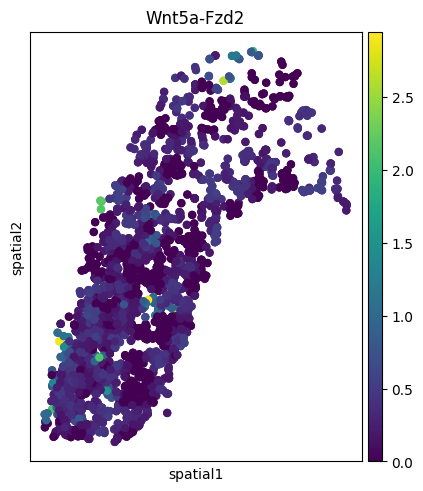

In [28]:
sq.pl.spatial_scatter(
    adata_rna_lr,
    shape=None,
    color=['Wnt5a-Fzd2'],
    size=100
)

# plot the direction only for the significant spots for focused metapath

In [29]:
from RegChat import analysis

In [36]:
p_val_cutoff = 0.1

In [37]:
res_df = analysis.get_signifcant_node(adata_rna_final,result_LR, nei_adj,spot_loc,p_val_cutoff,type = 'mix',topk = 2)

In [38]:
color_map = {
    'Astro': '#2278B5',       # 蓝色
    'Ex-L2/3 IT':'#F57F20',  # 橙色
    'Ex-L4/5 IT': '#279E69',  # 绿色
    'Ex-L5 PT': '#D62A28',     # 蓝色
    'Ex-L5 NP': '#855AA5',  # 橙色
    'Ex-L6 IT': '#8D574C',  # 绿色
    'Ex-L6 CT': '#D87AB2',  # 橙色
    'Ex-L6b': '#B6BE62'
}
coord_df = spot_loc.copy()
cell_type = adata_rna_final.obs['cell_type']

In [39]:
cell_type = cell_type.astype(str)

In [40]:
coord_df['color'] = cell_type.map(color_map)

Text(0.5, 1.0, 'Communication Direction under: Wnt5a-Fzd2')

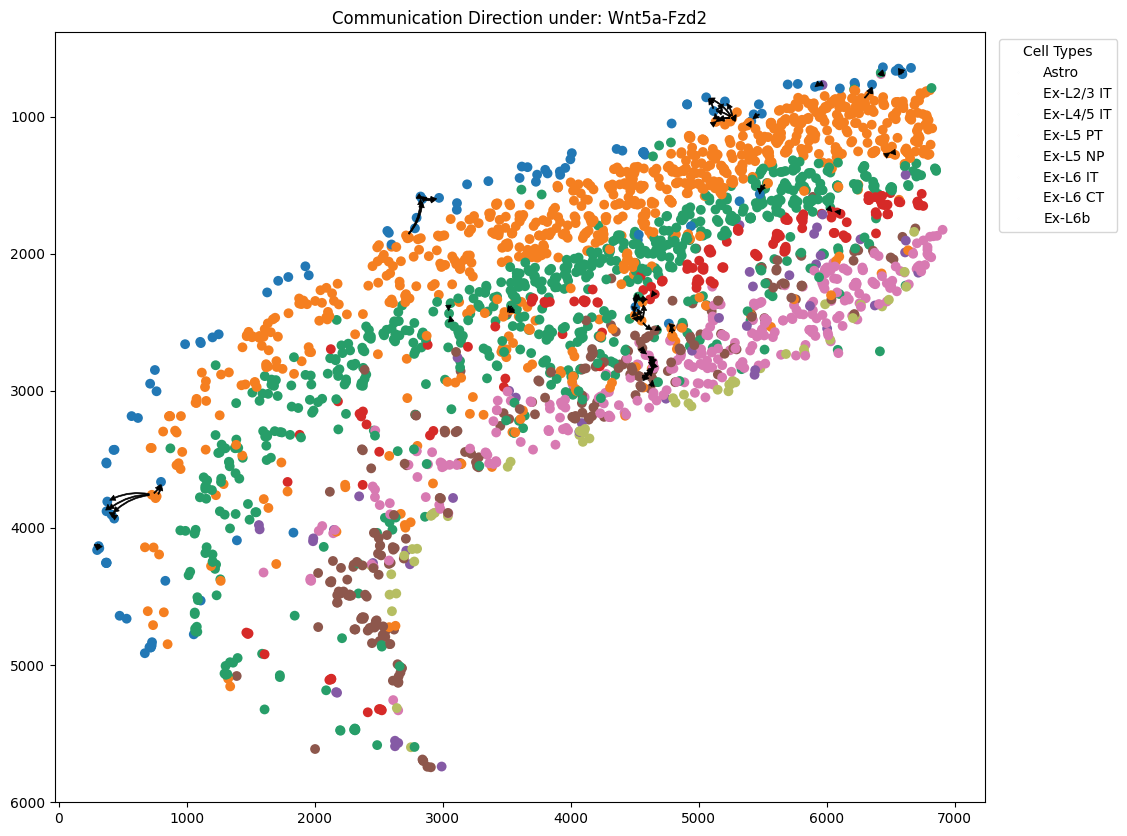

In [41]:
res_specific_df = res_df[res_df['LR_Name'].str.contains("Wnt5a-Fzd2")]
plt.figure(figsize=(12, 10))
scatter = plt.scatter(coord_df['y'], coord_df['x'],
                     c=coord_df['color'].tolist(), alpha=1, s=50, linewidths=0) 
plt.gca().invert_yaxis() 
for index, row in res_specific_df.iterrows():
    strength = row['Comm_Score']
    lw = max(0.5, strength*0.1)
    arrowstyle = ArrowStyle("Simple", head_length=0.5, head_width=0.5, tail_width=0.1)
    arrow = FancyArrowPatch((row['Sender_y'],row['Sender_x']), 
                            (row['Receiver_y'], row['Receiver_x']),
                            connectionstyle="arc3,rad=0.2", 
                            arrowstyle=arrowstyle, color='black', lw=lw,
                            mutation_scale=8)
    plt.gca().add_patch(arrow)
    
handles = [plt.Line2D([0], [0], marker='o', color='w', label=celltype, markerfacecolor=color, markersize=1)
           for celltype, color in color_map.items()]
plt.legend(handles=handles, title='Cell Types', bbox_to_anchor=(1.15, 1), loc= 'upper right')

plt.title('Communication Direction under: '+ "Wnt5a-Fzd2")